In [5]:
import numpy as np

INF = float('inf')

def floyd_warshall(graph):
    num_vertices = len(graph)
    dist = np.full((num_vertices, num_vertices), INF)

    # Initialize distances based on graph
    for i in range(num_vertices):
        for j in range(num_vertices):
            if i == j:
                dist[i][j] = 0
            elif graph[i][j] != 0:
                dist[i][j] = graph[i][j]

    # Floyd-Warshall Algorithm
    for k in range(num_vertices):
        for i in range(num_vertices):
            for j in range(num_vertices):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])

    return dist


Shortest Path Matrix for the N = 40 Circular Graph -- The complexity of this is O(N^3), potentially Djikstra's algorithm or Breadth First Programming would be more efficient; but if this only needs to be run once, is efficiency a very important factor?

In [6]:
N = 40
adj = np.eye(N)* 0
for i in range(1, N-1):
    adj[i, i-1] = adj[i, i+1] = 1

adj[0][1] = adj[0][N-1] = adj[N-1][0] = adj[N-1][N-2] = 1
shortest_paths = floyd_warshall(adj)
print(shortest_paths)

[[0. 1. 2. ... 3. 2. 1.]
 [1. 0. 1. ... 4. 3. 2.]
 [2. 1. 0. ... 5. 4. 3.]
 ...
 [3. 4. 5. ... 0. 1. 2.]
 [2. 3. 4. ... 1. 0. 1.]
 [1. 2. 3. ... 2. 1. 0.]]


Make a dictionary

In [7]:
shortestpathdict = {}
n = len(shortest_paths)
for i in range(n):
    for j in range(i + 1, n):
        if shortest_paths[i][j] in shortestpathdict:
            shortestpathdict[shortest_paths[i][j]].append((i, j))
        else:
            shortestpathdict[shortest_paths[i][j]] = [(i, j)]

print(shortestpathdict)

{1.0: [(0, 1), (0, 39), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39)], 2.0: [(0, 2), (0, 38), (1, 3), (1, 39), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (8, 10), (9, 11), (10, 12), (11, 13), (12, 14), (13, 15), (14, 16), (15, 17), (16, 18), (17, 19), (18, 20), (19, 21), (20, 22), (21, 23), (22, 24), (23, 25), (24, 26), (25, 27), (26, 28), (27, 29), (28, 30), (29, 31), (30, 32), (31, 33), (32, 34), (33, 35), (34, 36), (35, 37), (36, 38), (37, 39)], 3.0: [(0, 3), (0, 37), (1, 4), (1, 38), (2, 5), (2, 39), (3, 6), (4, 7), (5, 8), (6, 9), (7, 10), (8, 11), (9, 12), (10, 13), (11, 14), (12, 15), (13, 16), (14, 17), (15, 18), (16, 19), (17, 20), (18, 21), (19, 22), (20, 23),

Run the Spatial Correlation Simulation

In [8]:
import networkx as nx
G = nx.from_numpy_array(adj)

E = list(G.edges)

In [9]:
import numpy as np

class Counter(dict):
    largest_non_zero = 0
    def increment(self, item, delta = 1):
        new_val = delta + self.pop(item, 0)
        if new_val > 0: 
            self[item] = new_val
            if (item != 0) and (new_val > self.largest_non_zero):
                self.largest_non_zero = new_val

def y(x):
    return 2**x


def jaccard_index(a, b):
    intersection = (a & b).bit_count()
    union = (a | b).bit_count()
    return intersection / union if union else 0

def find_tranformation_matrix(b, E, N, Tmax, stopping_crit = 0):

    M = np.shape(E)[0]
    ## find the number of events that occur in the interval from T = 0 to T = Tmax
    n = np.random.poisson(lam = Tmax*(N+b*M))

    ## find times for all events
    times = np.sort(np.random.uniform(0, Tmax, n))
    R = np.zeros(n, dtype = int)

    ## initialize the transformation matrix X    
    X = [2**i for i in range(N)][::-1]
    ## initialize the Similarity matrix J
    J = np.eye(N)

    counts = Counter()
    for element in X:
        counts.increment(element, 1)

    # run simulation
    for t in range(n):
        
        if np.random.random() < N/(N + b*M):
            ## recovery event: 
            i = np.random.randint(N)
            # print(f"Recovery event of {i} which is {X[i]}")

            if X[i] != 0:
                
                counts.increment(X[i], -1)

                X[i] = 0

                counts.increment(0, 1)

                ## update the similarity matrix (find max over all time)
                for a in range(N):
                    new_val = jaccard_index(X[i], X[a])
                    if new_val > J[a, i]:
                        J[i, a] = J[a, i] = new_val
        
        ## infection event:
        else:

            i,j = E[np.random.randint(M)]
            # print(f"spreading event between {i} which is {X[i]} and {j} which is {X[j]}")
            if (X[i] != 0 or X[j] != 0) and X[i] != X[j]:
                    
                new = X[i] | X[j]
                counts.increment(X[i], -1)
                counts.increment(X[j], -1)
                counts.increment(new, 2)
                X[i] = X[j] = new

                ## update the similarity matrix:
                for a in range(N):
                    new_val = jaccard_index(X[i], X[a]) ## X[i] = X[j] after spreading event
                    if new_val > J[a, i]:
                        J[a, i] = J[i, a] = new_val
                    if new_val > J[a, j]:
                        J[a, j] = J[j, a] = new_val
                
        R[t] = non_zero_distinct_rows = len(counts) - (0 in counts)
        ## storing s1star for the largest non-zero count
        spatial = counts.largest_non_zero
        
        ## break the simulation because the pseudo mixing time has been found (the number of distinct rows and thus distinct columns is 2 or extinction, depending)

        if non_zero_distinct_rows == stopping_crit:
            times = times[:t+1]
            R = R[:t+1]
            break

    return times, R, spatial, J

In [22]:
Js = []
b = 0.5
Tmax = 100
for i in range(1500):
    times, R, spatial, J = find_tranformation_matrix(b, E, N, Tmax, 0)
    Js.append(J)

average = np.mean(Js, axis=0)

print(average)

[[1.         0.576      0.23481746 ... 0.10035079 0.23333333 0.57      ]
 [0.576      1.         0.57466667 ... 0.04       0.09301111 0.23193333]
 [0.23481746 0.57466667 1.         ... 0.01232222 0.03341429 0.09258095]
 ...
 [0.10035079 0.04       0.01232222 ... 1.         0.606      0.25483333]
 [0.23333333 0.09301111 0.03341429 ... 0.606      1.         0.58533333]
 [0.57       0.23193333 0.09258095 ... 0.25483333 0.58533333 1.        ]]


In [11]:
print(shortestpathdict)

{1.0: [(0, 1), (0, 39), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39)], 2.0: [(0, 2), (0, 38), (1, 3), (1, 39), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (8, 10), (9, 11), (10, 12), (11, 13), (12, 14), (13, 15), (14, 16), (15, 17), (16, 18), (17, 19), (18, 20), (19, 21), (20, 22), (21, 23), (22, 24), (23, 25), (24, 26), (25, 27), (26, 28), (27, 29), (28, 30), (29, 31), (30, 32), (31, 33), (32, 34), (33, 35), (34, 36), (35, 37), (36, 38), (37, 39)], 3.0: [(0, 3), (0, 37), (1, 4), (1, 38), (2, 5), (2, 39), (3, 6), (4, 7), (5, 8), (6, 9), (7, 10), (8, 11), (9, 12), (10, 13), (11, 14), (12, 15), (13, 16), (14, 17), (15, 18), (16, 19), (17, 20), (18, 21), (19, 22), (20, 23),

Make the K vs Spatial Correlation Graph

In [23]:
ks = []
spatialcorrs = []

for k, v in shortestpathdict.items():
    temp = []
    ks.append(k)
    for element in v:
        temp.append(average[element[0]][element[1]])
    spatialcorrs.append(np.mean(temp))

print(ks)
print(spatialcorrs)



[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]
[0.5786333333333333, 0.24205880952380956, 0.09566432539682541, 0.03739418650793651, 0.014540515873015875, 0.005395714285714286, 0.0019924603174603173, 0.0007542857142857143, 0.00031734126984126984, 0.0001442063492063492, 6.666666666666667e-05, 3.3333333333333335e-05, 3.3333333333333335e-05, 2.222222222222222e-05, 1.111111111111111e-05, 0.0, 0.0, 0.0, 0.0, 0.0]


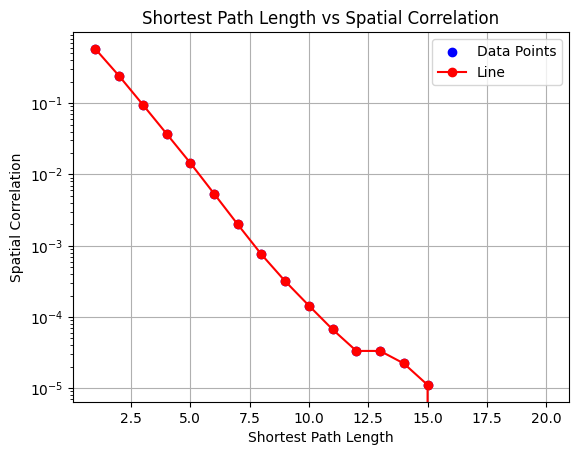

In [24]:
import matplotlib.pyplot as plt
# Plot scatter plot
plt.scatter(ks, spatialcorrs, color='blue', label='Data Points')

# Plot line joining points
plt.plot(ks, spatialcorrs, color='red', linestyle='-', marker='o', label='Line')
plt.yscale('log')
# Add labels and legend
plt.xlabel('Shortest Path Length')
plt.ylabel('Spatial Correlation')
plt.title('Shortest Path Length vs Spatial Correlation')
plt.legend()

# Show plot
plt.grid(True)
plt.show()